## No restrictions on error of parallax

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
g = np.genfromtxt('gaia_data_csv',skip_header=1,delimiter=',')

# e_bp_rp 114
# bp_rp 93
# rp 90
# bp 85
# g 80
# parallax 39
# parallax error 40
# E(B-V) 12
# (B-V)0 13

# find out how many parallaxes are negative, and how many parallaxes are NaN

x=0
for line in g:
    if line[39] <= 0:
        x=x+1
        
y=0
for line in g:
    if np.isnan(line[39]) == True:
        y=y+1
                
print('Total number of objects in file:',int(np.size(np.transpose(g)[0])))
print('Number of non-positive parallaxes:',x)
print('Number of objects without a measurement for the parallax:',y)
        
# remove non-positive parallaxes and lines where parallax is NaN by creating array
# containing the indices of the lines where that is the case:

a=np.array([])
for i in np.arange(int(np.size(np.transpose(g)[0]))):
    if (g[int(i)][39] <= 0) or (np.isnan(g[int(i)][39]) == True):
        a=np.append(a,i)

a = a.astype(int)        # np.delete wants integers
        
g = np.transpose(np.delete(g,a,0))   # transpose since columns and rows are mixed up

# assign for better readability

parallax = g[39]          # in mas
parallax_e = g[40]        # in mas
G = g[80]                 # in mag
bp_rp = g[93]             # in mag
B_V = g[12]+g[13]         # in mag
E_B_V = g[12]             # in mag
B_V_0 = g[13]             # in mag

Total number of objects in file: 18373
Number of non-positive parallaxes: 533
Number of objects without a measurement for the parallax: 62


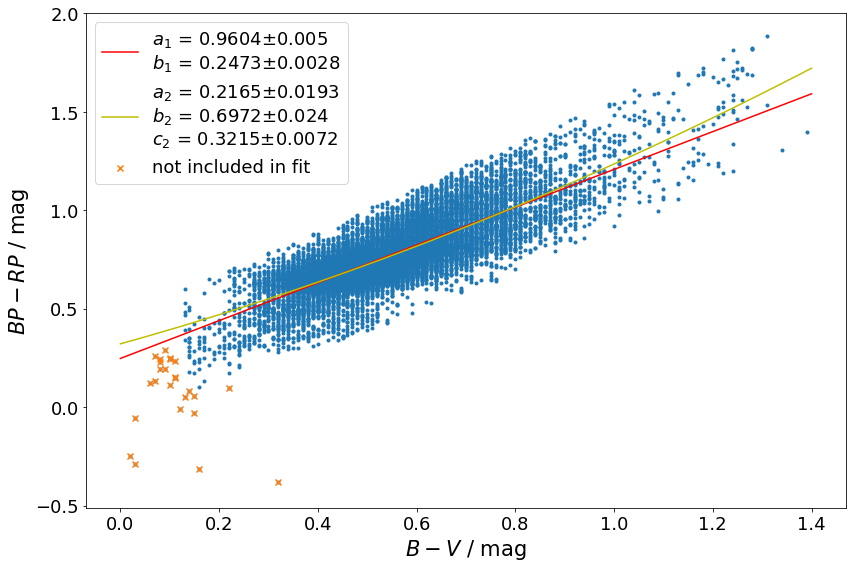

In [3]:
def lin(x,a,b):
    return a*x+b

def parab(x,a,b,c):
    return a*x**2+b*x+c

# prepare B_V and bp_rp for fit: discard those where bp_rp < 0.1, B_V < 0.14

f=np.array([])
for i in range(np.size(B_V)):
    if B_V[i] < 0.13 or bp_rp[i] < 0.1:
        f=np.append(f,i)
        
f=f.astype(int)

B_V_fit = np.delete(B_V,f)
bp_rp_fit = np.delete(bp_rp,f)

f1=np.array([])
for i in range(np.size(B_V)):
    if i not in f:
        f1=np.append(f1,i)

f1=f1.astype('int')

crossed_BV = np.delete(B_V,f1)
crossed_bprp = np.delete(bp_rp,f1)

# carry out fit

popt1,pcov1 = curve_fit(lin,B_V_fit,bp_rp_fit)

popt2,pcov2 = curve_fit(parab,B_V_fit,bp_rp_fit)

x = np.linspace(0,1.4)

plt.figure(figsize=(12,8))
plt.scatter(B_V,bp_rp,marker='.')
plt.scatter(crossed_BV,crossed_bprp,marker='x',label='not included in fit')
plt.plot(x,lin(x,popt1[0],popt1[1]),color='r',label='$a_1$ = '+str(round(popt1[0],4))+'$\pm$'+str(round(np.sqrt(pcov1[0][0]),4))+'\n$b_1$ = '+str(round(popt1[1],4))+'$\pm$'+str(round(np.sqrt(pcov1[1][1]),4)))
plt.plot(x,parab(x,popt2[0],popt2[1],popt2[2]),color='y',label='$a_2$ = '+str(round(popt2[0],4))+'$\pm$'+str(round(np.sqrt(pcov2[0][0]),4))+'\n$b_2$ = '+str(round(popt2[1],4))+'$\pm$'+str(round(np.sqrt(pcov2[1][1]),4))+'\n$c_2$ = '+str(round(popt2[2],4))+'$\pm$'+str(round(np.sqrt(pcov2[2][2]),4)))
plt.xlabel('$B-V$ / mag',size=21)
plt.ylabel('$BP-RP$ / mag',size=21)
#plt.title('BP$-$RP vs. $(\mathrm{B}-\mathrm{V})_{\mathrm{HES}}$',size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('Abbildungen/BP_RP_vs_B_V_fit.png')

In [4]:
# define e_bp_rp calculated from fit
# linear fit, since at the edges there aren't many objects anyway

bp_rp_0 = 0.9604*B_V_0 + 0.2473

e_bp_rp = bp_rp - bp_rp_0

# extinction in G band

c1=0.9761*np.ones(np.size(G))
c2=-0.1704*np.ones(np.size(G))
c3=0.0086*np.ones(np.size(G))
c4=0.0011*np.ones(np.size(G))
c5=-0.0438*np.ones(np.size(G))
c6=0.0013*np.ones(np.size(G))
c7=0.0099*np.ones(np.size(G))

A_0=3.1*E_B_V

k_G=c1+c2*bp_rp_0+c3*bp_rp_0**2+c4*bp_rp_0**3+c5*A_0+c6*A_0**2+c7*bp_rp_0*A_0

A_G=k_G*A_0

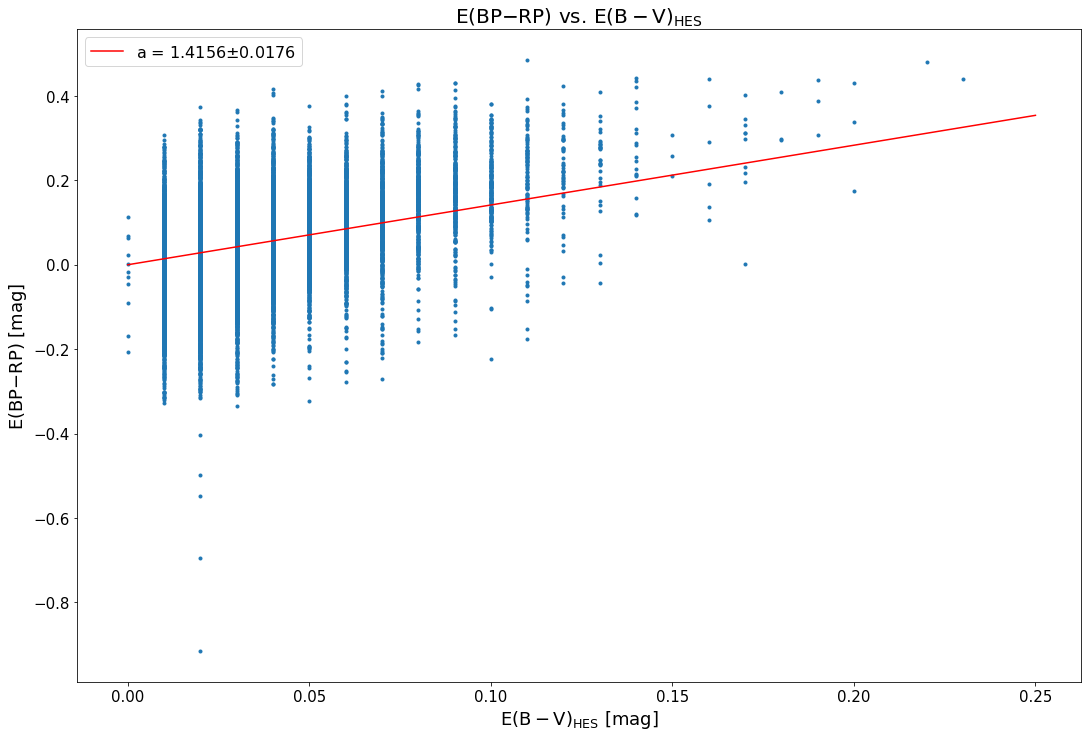

In [5]:
# comparison gaia e(bp-rp) with e(b-v)

def redtrans(x,a):
    return a*x

popt3,pcov3 = curve_fit(redtrans,E_B_V,e_bp_rp)

x = np.linspace(0,0.25)
plt.figure(figsize=(18,12))
plt.scatter(E_B_V,e_bp_rp,marker='.')
plt.plot(x,redtrans(x,popt3[0]),color='r',label='a = '+str(round(popt3[0],4))+'$\pm$'+str(round(np.sqrt(pcov3[0][0]),4)))
plt.xlabel('$\mathrm{E(B}-\mathrm{V})_{\mathrm{HES}}$ [mag]',size=18)
plt.ylabel('E(BP$-$RP) [mag]',size=18)
plt.title('E(BP$-$RP) vs. $\mathrm{E(B}-\mathrm{V})_{\mathrm{HES}}$',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=16)
plt.savefig('Abbildungen/E_BP_RP_vs_E_B_V.png')

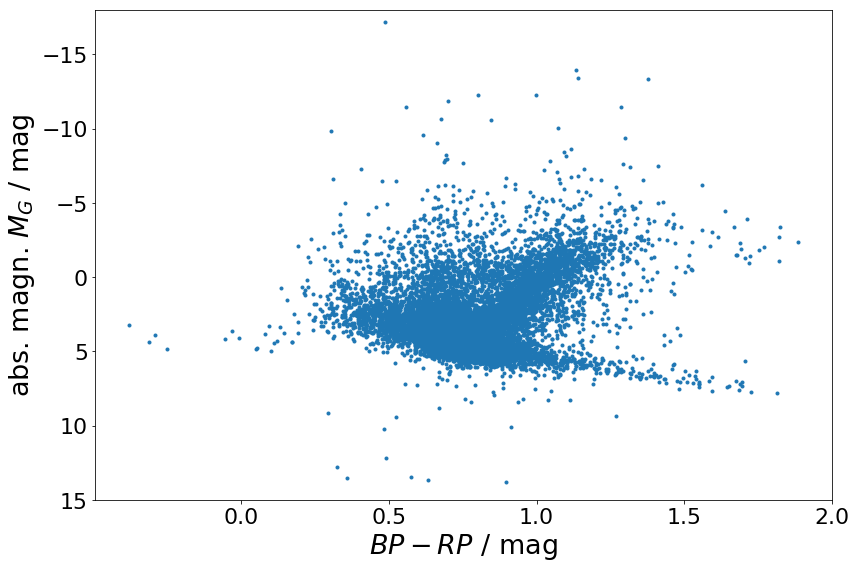

In [6]:
M_G = G + 5 + 5*np.log10(parallax/1000) -A_G # absolute magnitude in mag, derived using the distance modulus

plt.figure(figsize=(12,8))
plt.scatter(bp_rp,M_G,marker='.')
plt.ylim(15,-18)
plt.yticks(size=22)
plt.xticks(size=22)
plt.xlabel('$BP-RP$ / mag',size=27)
plt.ylabel('abs. magn. $M_G$ / mag',size=27)
plt.tight_layout()
#plt.title('HRD of 17778 stars (Christlieb et al. 2005) using GAIA DR2 data, only positive parallaxes',size=20)
plt.savefig('Abbildungen/HRD_18095stars_without_conditions.png')

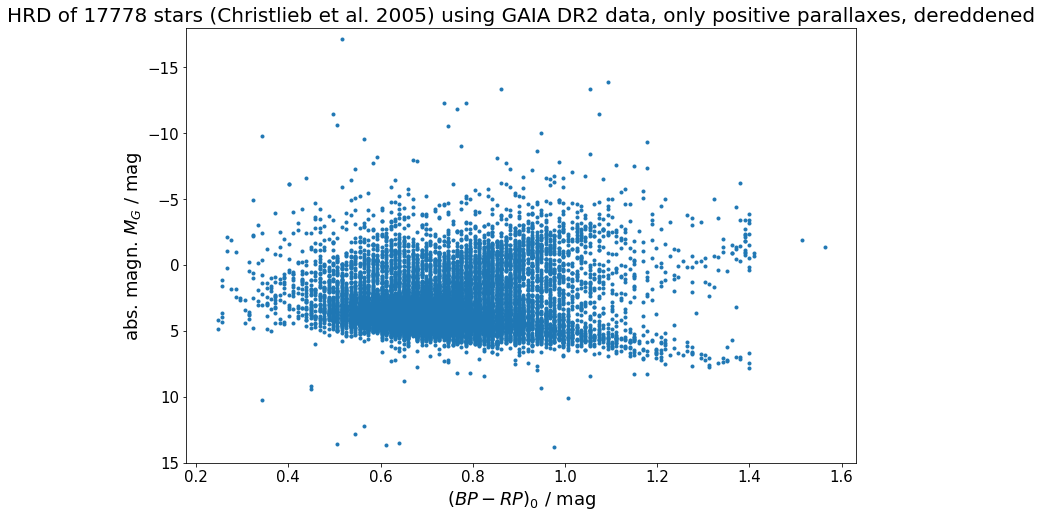

In [7]:
M_G = G + 5 + 5*np.log10(parallax/1000) -A_G # absolute magnitude in mag, derived using the distance modulus

plt.figure(figsize=(12,8))
plt.scatter(bp_rp_0,M_G,marker='.')
plt.ylim(15,-18)
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('$(BP-RP)_0$ / mag',size=18)
plt.ylabel('abs. magn. $M_G$ / mag',size=18)
plt.title('HRD of 17778 stars (Christlieb et al. 2005) using GAIA DR2 data, only positive parallaxes, dereddened',size=20)
plt.savefig('Abbildungen/HRD_18095stars_dered.png')

## Relative parallax error must be smaller than 20%

In [8]:
g = np.genfromtxt('gaia_data_csv',skip_header=1,delimiter=',')

# find out how many parallaxes are negative, and how many parallaxes are NaN

x=0
for line in g:
    if line[39] <= 0:
        x=x+1
        
y=0
for line in g:
    if np.isnan(line[39]) == True:
        y=y+1
        
# note that for some lines, both the parallax are NaN
        
print('Total number of objects in file:',int(np.size(np.transpose(g)[0])))
print('Number of non-positive parallaxes:',x)
print('Number of objects without a measurement for the parallax:',y)
# remove non-positive parallaxes and lines where bp_rp or parallax is NaN by creating array
# containing the indices of the lines where that is the case:

a=np.array([])
for i in np.arange(int(np.size(np.transpose(g)[0]))):
    if (g[int(i)][39] <= 0) or (np.isnan(g[int(i)][39]) == True):
        a=np.append(a,i)

a = a.astype(int)        # np.delete wants integers
        
g = np.transpose(np.delete(g,a,0))   # transpose since columns and rows are mixed up

Total number of objects in file: 18373
Number of non-positive parallaxes: 533
Number of objects without a measurement for the parallax: 62


In [9]:
g1 = np.transpose(g)

# find out how many parallaxes' relative precision is too unprecise

t=0
for line in g1:
    if np.abs(line[41]) < 5:
        t=t+1
        
print('Number of parallaxes with relative precision worse than 20% (of remaining 17511 objects):',t)
print('Number of objects left to plot:',int(np.size(np.transpose(g1)[0])-t))

# remove objects where parallax/parallax_error < 5 as above

b=np.array([])
for i in np.arange(int(np.size(np.transpose(g1)[0]))):
    if np.abs(g1[i][41]) <= 5:
        b=np.append(b,i)
        
b = b.astype(int)

g1 = np.transpose(np.delete(g1,b,0))

parallax20 = g1[39]
parallax_e20 = g1[40]
G20 = g1[80]
bp_rp20 = g1[93]
E_B_V20 = g1[12]
B_V20 = g1[13]

bp_rp_020 = 0.9604*B_V20 + 0.2473

e_bp_rp020 = bp_rp20 - bp_rp_020

# extinction in G band

c1=0.9761*np.ones(np.size(G20))
c2=-0.1704*np.ones(np.size(G20))
c3=0.0086*np.ones(np.size(G20))
c4=0.0011*np.ones(np.size(G20))
c5=-0.0438*np.ones(np.size(G20))
c6=0.0013*np.ones(np.size(G20))
c7=0.0099*np.ones(np.size(G20))

A_020=3.1*E_B_V20

k_G20=c1+c2*bp_rp_020+c3*bp_rp_020**2+c4*bp_rp_020**3+c5*A_020+c6*A_020**2+c7*bp_rp_020*A_020

A_G20=k_G20*A_020

Number of parallaxes with relative precision worse than 20% (of remaining 17511 objects): 7573
Number of objects left to plot: 10205


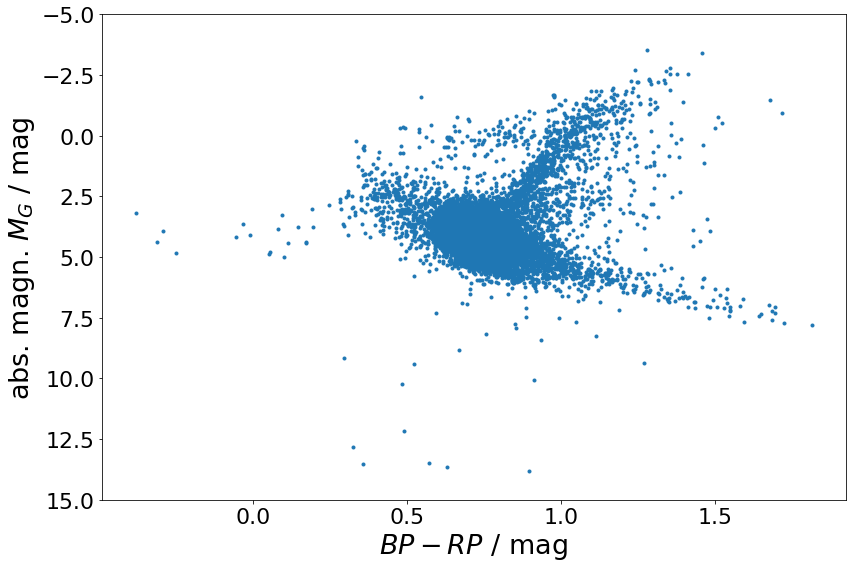

In [10]:
M_G20 = G20 + 5 + 5*np.log10(parallax20/1000) - A_G20  # absolute magnitude in mag, derived using the distance modulus
                                            # parallax is in mas --> factor 1/1000

plt.figure(figsize=(12,8))
plt.scatter(bp_rp20,M_G20,marker='.')
plt.ylim(15,-5)
plt.yticks(size=22)
plt.xticks(size=22)
plt.xlabel('$BP-RP$ / mag',size=27)
plt.ylabel('abs. magn. $M_G$ / mag',size=27)
plt.tight_layout()
#plt.title('Only objects where the relative error of the parallax measurement is < 20%',size=20)
plt.savefig('Abbildungen/HRD_18095stars_paral_prec.png')

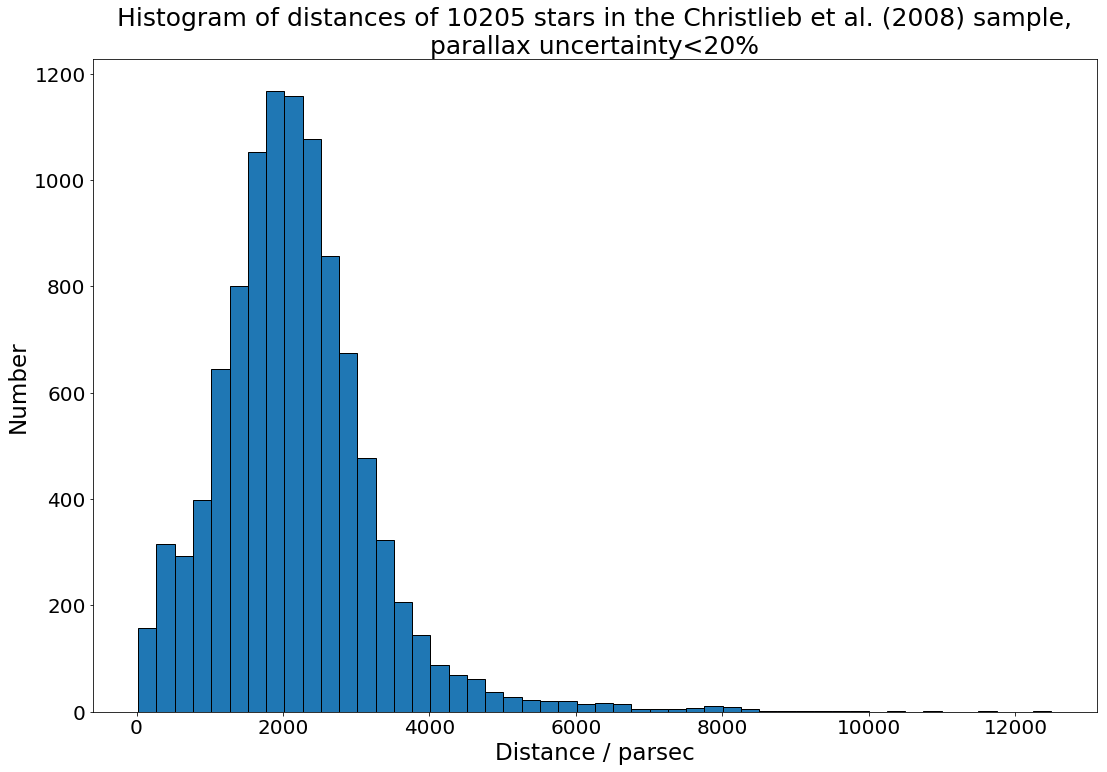

In [11]:
distance20 = 1000/parallax20

plt.figure(figsize=(18,12))
plt.hist(distance20,50,edgecolor='black')
plt.xlabel('Distance / parsec',size=23)
plt.ylabel('Number',size=23)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title('Histogram of distances of 10205 stars in the Christlieb et al. (2008) sample,\nparallax uncertainty<20%',size=25)
plt.savefig('Abbildungen/distances_1stsample.png')

In [12]:
# to create a table with all that I've calculated; first find out indices 
# which will have NaN due to parallax condition: stored in a

g = np.genfromtxt('gaia_data_csv',skip_header=1,delimiter=',')

a=np.array([])
for i in np.arange(int(np.size(np.transpose(g)[0]))):
    if (g[int(i)][39] <= 0) or (np.isnan(g[int(i)][39]) == True) or (np.abs(g[i][41]) <= 5):
        a=np.append(a,i)

# indices not in a
b=np.array([])
for i in np.arange(int(np.size(np.transpose(g)[0]))):
    if (g[int(i)][39] > 0) and (np.isnan(g[int(i)][39]) == False) and (np.abs(g[i][41]) > 5):
        b=np.append(b,i)
        
a = a.astype(int)        # np.delete wants integers
        
g = np.transpose(np.delete(g,a,0))   # transpose since columns and rows are mixed up

In [13]:
abs_mag=np.zeros(18373)

for i in a:
    abs_mag[i]=np.nan

for i in range(np.size(M_G20)):
    abs_mag[int(b[i])]=M_G20[i]


extinc=np.zeros(18373)

for i in a:
    extinc[i]=np.nan

for i in range(np.size(M_G20)):
    extinc[int(b[i])]=A_G20[i]
    

colourr=np.zeros(18373)

for i in a:
    colourr[i]=np.nan

for i in range(np.size(M_G20)):
    colourr[int(b[i])]=bp_rp_020[i]
    
    
distanz=np.zeros(18373)

for i in a:
    distanz[i]=np.nan

for i in range(np.size(M_G20)):
    distanz[int(b[i])]=distance20[i]
    
    
df = pd.read_csv(r'transitional_table1.csv')

abs_magn = pd.DataFrame(data = abs_mag,columns=['M_G'])
extinction = pd.DataFrame(data = extinc,columns=['A_G'])
colour = pd.DataFrame(data = colourr,columns=['bp_rp0'])
distance = pd.DataFrame(data = distanz,columns=['distance'])

new = pd.concat([df['HE'],df['HESid'],df['source_id_cone'],df['ra_cone'],df['dec_cone'],df['parallax_cone'],df['parallax_error_cone'],df['phot_g_mean_mag_cone'],df['bp_rp_cone'],abs_magn,extinction,colour,distance],axis=1)

new.rename(columns={'source_id_cone':'source_id','ra_cone':'ra','dec_cone':'dec','parallax_cone':'parallax','parallax_error_cone':'parallax_error','phot_g_mean_mag_cone':'Gmag','bp_rp_cone':'bp_rp'},inplace=True)

new.to_csv('1stsample.csv',index=False)

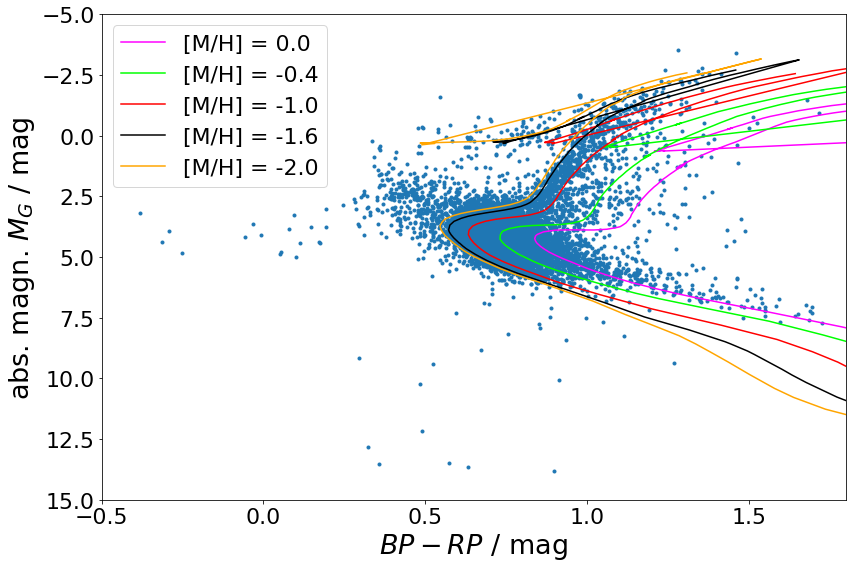

In [14]:
M_G20 = G20 + 5 + 5*np.log10(parallax20/1000) -A_G20   # absolute magnitude in mag, derived using the distance modulus
                                            # parallax is in mas --> factor 1/1000
    
iso0 = np.transpose(np.genfromtxt('isochrones/isochrone_12Gyr__0_0.txt',skip_header=12,skip_footer=12))
iso01 = np.transpose(np.genfromtxt('isochrones/isochrone_12Gyr__0_4.txt',skip_header=12,skip_footer=12))
iso1 = np.transpose(np.genfromtxt('isochrones/isochrone_12Gyr__1_0.txt',skip_header=12,skip_footer=12))
iso2 = np.transpose(np.genfromtxt('isochrones/isochrone_12Gyr__1_6.txt',skip_header=12,skip_footer=12))
iso3 = np.transpose(np.genfromtxt('isochrones/isochrone_12Gyr__2_0.txt',skip_header=12,skip_footer=12))
    
plt.figure(figsize=(12,8))
plt.scatter(bp_rp20,M_G20,marker='.')
plt.plot(iso0[12]-iso0[13],iso0[11],label='[M/H] = 0.0',color='magenta')
plt.plot(iso01[12]-iso01[13],iso01[11],label='[M/H] = -0.4',color='lime')
plt.plot(iso1[12]-iso1[13],iso1[11],label='[M/H] = -1.0',color='r')
plt.plot(iso2[12]-iso2[13],iso2[11],label='[M/H] = -1.6',color='black')
plt.plot(iso3[12]-iso3[13],iso3[11],label='[M/H] = -2.0',color='orange')
plt.ylim(15,-5)
plt.xlim(-0.5,1.8)
plt.yticks(size=22)
plt.xticks(size=22)
plt.legend(fontsize=22)
plt.xlabel('$BP-RP$ / mag',size=27)
plt.ylabel('abs. magn. $M_G$ / mag',size=27)
plt.tight_layout()
#plt.title('Only objects where the relative error of the parallax measurement is < 20%, with isochrones (12Gyr)',size=20)
plt.savefig('Abbildungen/HRD_18095stars_paral_prec_iso.png')

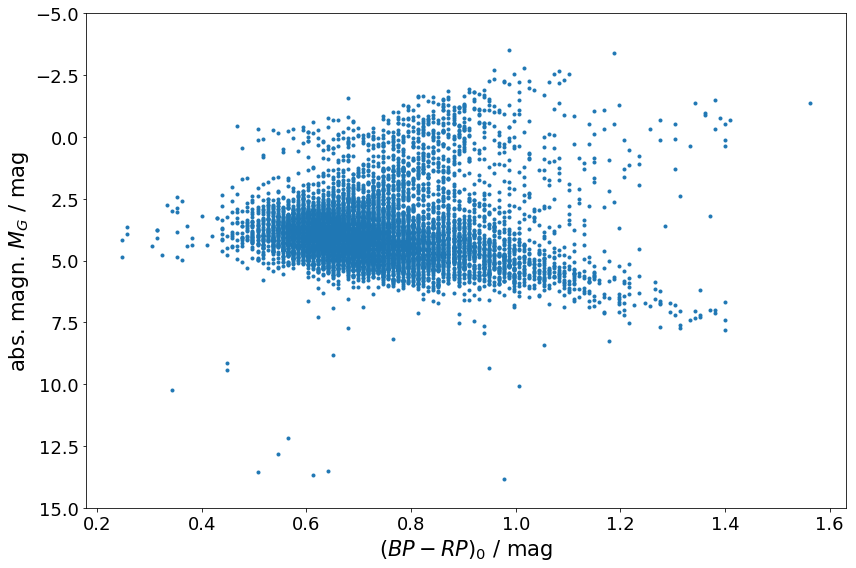

In [15]:
M_G20 = G20 + 5 + 5*np.log10(parallax20/1000) - A_G20 # absolute magnitude in mag, derived using the distance modulus

plt.figure(figsize=(12,8))
plt.scatter(bp_rp_020,M_G20,marker='.')
plt.ylim(15,-5)
plt.yticks(size=18)
plt.xticks(size=18)
plt.xlabel('$(BP-RP)_0$ / mag',size=21)
plt.ylabel('abs. magn. $M_G$ / mag',size=21)
plt.tight_layout()
#plt.title('Only objects where the relative error of the parallax measurement is < 20%, dereddened',size=20)
plt.savefig('Abbildungen/HRD_18095stars_paral_prec_dered.png')

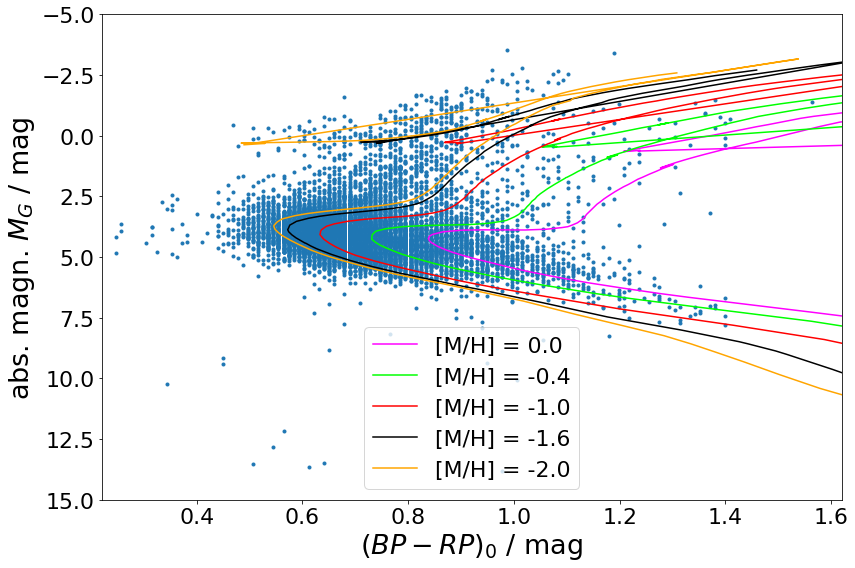

In [16]:
M_G20 = G20 + 5 + 5*np.log10(parallax20/1000) - A_G20 # absolute magnitude in mag, derived using the distance modulus

plt.figure(figsize=(12,8))
plt.scatter(bp_rp_020,M_G20,marker='.')
plt.plot(iso0[12]-iso0[13],iso0[11],label='[M/H] = 0.0',color='magenta')
plt.plot(iso01[12]-iso01[13],iso01[11],label='[M/H] = -0.4',color='lime')
plt.plot(iso1[12]-iso1[13],iso1[11],label='[M/H] = -1.0',color='r')
plt.plot(iso2[12]-iso2[13],iso2[11],label='[M/H] = -1.6',color='black')
plt.plot(iso3[12]-iso3[13],iso3[11],label='[M/H] = -2.0',color='orange')
plt.ylim(15,-5)
plt.xlim(0.22,1.62)
plt.yticks(size=22)
plt.xticks(size=22)
plt.xlabel('$(BP-RP)_0$ / mag',size=27)
plt.ylabel('abs. magn. $M_G$ / mag',size=27)
plt.legend(fontsize=22)
plt.tight_layout()
#plt.title('Only objects where the relative error of the parallax measurement\n is < 20%, dereddened, with isochrones (12Gyr)',size=20)
plt.savefig('Abbildungen/HRD_18095stars_paral_prec_dered_iso.png')